How scalable is the score matching loss as introduced by Hyvarinen et.al when for large models and autodiff engines for training? The loss is again $$\mathbb{E}_{x \sim p_\mathbf{x}}\left[ trace(\nabla_x \phi(x, \theta)) + \frac{1}{2} || \phi(x, \theta) ||_2^2                     \right]$$ where $\phi$ is the score. This depends on the trace of the Hessian of our model wrt to data which is $O(D)$ times more expensive than the gradient for modern autodiff engines (at least for PyTorch) as we will see below. $D$ is the dimensionality of each data point; for images this is in the thousands. $\textbf{this is the same issue with eikonal loss with implicit functions where we need to compute the gradient with respect to the input data. }.$
Better way to finds these Hessians and gradients through autodiff?


## Pytorch autodiff

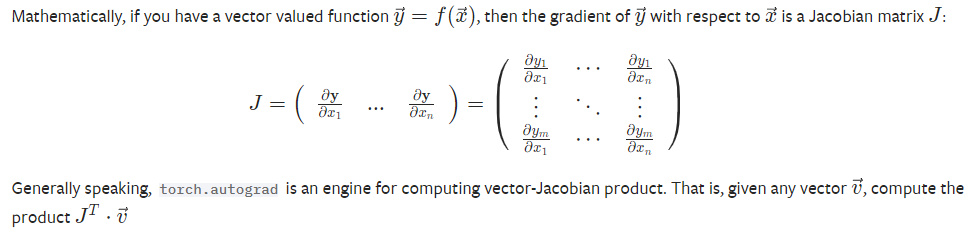

Let's assume we have a vector valued function $\mathbf{F}(\mathbf{x}) = \mathbf{F}(x_1, x_2, x_3, x_4) = \begin{bmatrix} f_1 (x_1, x_2, x_3, x_4) \\ f_2(x_1, x_2, x_3, x_4) \\ f_3(x_1, x_2, x_3, x_4) \\ f_4(x_1, x_2, x_3, x_4) \end{bmatrix} = \begin{bmatrix} 1 & 0 & 0 & 4 \\ 1 & 2 & 0 & 0 \\ 0 & 2 & 3 & 0 \\ 0 & 2 & 0 & 4 
\end{bmatrix} \mathbf{x}^2 = \mathbf{C} \mathbf{x}^2$ 

In [6]:
import torch 
def f(x): 
    coeffs = torch.Tensor([[1, 0, 0, 4], 
                           [1, 2, 0, 0], 
                           [0, 2, 3, 0], 
                           [0, 2, 0, 4]])
    return coeffs @ ( x * x)

x = torch.ones(4, requires_grad=True)

In [7]:
def jacobian(y, x, create_graph=False):   
    jac = []                                                                      
    flat_y = y.reshape(-1)                                                             
    grad_y = torch.zeros_like(flat_y)
    for i in range(len(flat_y)):                                                              
        grad_y[i] = 1.                                                                 
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)      

In [8]:
jacobian(f(x), x)

tensor([[2., 0., 0., 8.],
        [2., 4., 0., 0.],
        [0., 4., 6., 0.],
        [0., 4., 0., 8.]])

Essentially, we are asking autodiff to compute $J^T v$ for specific vectors $v$ (these are specified in the $\textit{grad_y}$ argument of autodiff): Let $$\mathbf{J} = \begin{bmatrix} \frac{\partial f_1}{\partial_{x_1}} & \frac{\partial f_1}{\partial_{x_2}}  & \frac{\partial f_1}{\partial_{x_3}}  & \frac{\partial f_1}{\partial_{x_4}}  \\  
\frac{\partial f_2}{\partial_{x_1}} & \frac{\partial f_2}{\partial_{x_2}}  & \frac{\partial f_2}{\partial_{x_3}}  & \frac{\partial f_2}{\partial_{x_4}} \\  
\frac{\partial f_3}{\partial_{x_1}} & \frac{\partial f_3}{\partial_{x_2}}  & \frac{\partial f_3}{\partial_{x_3}}  & \frac{\partial f_3}{\partial_{x_4}} \\  \frac{\partial f_4}{\partial_{x_1}} & \frac{\partial f_4}{\partial_{x_2}}  & \frac{\partial f_4}{\partial_{x_3}}  & \frac{\partial f_4}{\partial_{x_4}}\end{bmatrix} $$ So 

$$\mathbf{J}^T = \begin{bmatrix} \frac{\partial f_1}{\partial_{x_1}} & \frac{\partial f_2}{\partial_{x_1}} & \frac{\partial f_3}{\partial_{x_1}} & \frac{\partial f_4}{\partial_{x_1}} \\ \frac{\partial f_1}{\partial_{x_2}} & \frac{\partial f_2}{\partial_{x_2}} & \frac{\partial f_3}{\partial_{x_2}} & \frac{\partial f_4}{\partial_{x_2}}  \\ \frac{\partial f_1}{\partial_{x_3}} & \frac{\partial f_2}{\partial_{x_3}} & \frac{\partial f_3}{\partial_{x_3}} & \frac{\partial f_4}{\partial_{x_3}}  \\ \frac{\partial f_1}{\partial_{x_4}} & \frac{\partial f_2}{\partial_{x_4}} & \frac{\partial f_3}{\partial_{x_4}} & \frac{\partial f_4}{\partial_{x_4}}  \end{bmatrix} $$


and now to get the first row of the jacobian we set $\mathbf{v} = \begin{bmatrix} 1 & 0 & 0 & 0   \end{bmatrix}^T $ (since $\mathbf{J}^T v = \begin{bmatrix} \frac{\partial f_1}{\partial_{x_1}} & \frac{\partial f_1}{\partial_{x_2}}  & \frac{\partial f_1}{\partial_{x_3}}  & \frac{\partial f_1}{\partial_{x_4}}\end{bmatrix} = \begin{bmatrix} 2 & 0 & 0 & 8\end{bmatrix} )$, to get the second row of the jacobianm we set $\mathbf{v} = \begin{bmatrix} 0 & 1 & 0 & 0 \end{bmatrix} $ etc.

This is expensive but it gets worse with the Hessian:

In [9]:
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)   

In [10]:
hessian(f(x), x)

tensor([[[2., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 8.]],

        [[2., 0., 0., 0.],
         [0., 4., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 4., 0., 0.],
         [0., 0., 6., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 4., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 8.]]])

Essentially, the Hessian of each function $f_i$ is a $4 \times 4$ matrix equal to $$ \begin{bmatrix} \frac{\partial^2 f_i}{\partial x_1^2} &  \frac{\partial^2 f_i}{\partial x_1\partial x_2} & \frac{\partial^2 f_i}{\partial x_1\partial x_3} & \frac{\partial^2 f_i}{\partial x_1\partial x_4} \\  
\frac{\partial^2 f_i}{\partial x_1 \partial x_2} &  \frac{\partial^2 f_i}{\partial x_2^2} & \frac{\partial^2 f_i}{\partial x_2\partial x_3} & \frac{\partial^2 f_i}{\partial x_2\partial x_4}   \\
 \frac{\partial^2 f_i}{\partial x_3x_1} &  \frac{\partial^2 f_i}{\partial x_3\partial x_2} & \frac{\partial^2 f_i}{\partial x_3^2} & \frac{\partial^2 f_i}{\partial x_3\partial x_4} \\ 
  \frac{\partial^2 f_i}{\partial x_4\partial x_1} &  \frac{\partial^2 f_i}{\partial x_4\partial x_2} & \frac{\partial^2 f_i}{\partial x_4\partial x_3} & \frac{\partial^2 f_i}{\partial x_4^2}
\end{bmatrix} $$

So the Hessian of $\mathbf{F}$ is a $4 \times 4 \times 4 $ tensor. To compute we flatten the Jacobian to a $16 \times 4$ matrix and regard each of its entry as a new function of $\mathbf{x}$ 

$$
\mathbf{f} = \begin{bmatrix}
f_{11}(\mathbf{x}) \\
f_{12}(\mathbf{x}) \\
f_{13}(\mathbf{x}) \\
f_{14}(\mathbf{x}) \\
f_{21}(\mathbf{x}) \\
f_{22}(\mathbf{x}) \\
f_{23}(\mathbf{x}) \\
f_{24}(\mathbf{x}) \\
f_{31}(\mathbf{x}) \\
f_{32}(\mathbf{x}) \\
f_{33}(\mathbf{x}) \\
f_{34}(\mathbf{x}) \\
f_{41}(\mathbf{x}) \\
f_{42}(\mathbf{x}) \\
f_{43}(\mathbf{x}) \\
f_{44}(\mathbf{x}) \\
\end{bmatrix} = 
\begin{bmatrix} \frac{\partial f_1}{\partial_{x_1}} \\ \frac{\partial f_1}{\partial_{x_2}}  \\ \frac{\partial f_1}{\partial_{x_3}}  \\ \frac{\partial f_1}{\partial_{x_4}}  \\
\frac{\partial f_2}{\partial_{x_1}} \\ \frac{\partial f_2}{\partial_{x_2}}  \\ \frac{\partial f_2}{\partial_{x_3}}  \\ \frac{\partial f_2}{\partial_{x_4}} \\
\frac{\partial f_3}{\partial_{x_1}} \\ \frac{\partial f_3}{\partial_{x_2}}  \\ \frac{\partial f_3}{\partial_{x_3}}  \\ \frac{\partial f_3}{\partial_{x_4}} \\  \frac{\partial f_4}{\partial_{x_1}} \\ \frac{\partial f_4}{\partial_{x_2}}  \\ \frac{\partial f_4}{\partial_{x_3}}  \\ \frac{\partial f_4}{\partial_{x_4}}\end{bmatrix} \Rightarrow \nabla_\mathbf{x} \mathbf{f} = \begin{bmatrix} 
\frac{\partial f_{11}}{\partial x_1} & \frac{\partial f_{11}}{\partial x_1}  & \frac{\partial f_{11}}{\partial x_1}  & \frac{\partial f_{11}}{\partial x_1} \\ 
\frac{\partial f_{44}}{\partial x_1} & \frac{\partial f_{44}}{\partial x_1}  & \frac{\partial f_{44}}{\partial x_1}  & \frac{\partial f_{44}}{\partial x_1}
\end{bmatrix} \Rightarrow \nabla_\mathbf{x} \mathbf{f}^T = \begin{bmatrix} 
\frac{\partial f_{11}}{\partial x_1} & \frac{\partial f_{12}}{\partial x_1}  & ... & \frac{\partial f_{44}}{\partial x_1} \\ 
\frac{\partial f_{11}}{\partial x_2} & \frac{\partial f_{12}}{\partial x_2}  & ...  & \frac{\partial f_{44}}{\partial x_2} \\ 
\frac{\partial f_{11}}{\partial x_3} & \frac{\partial f_{12}}{\partial x_3}  & ...  & \frac{\partial f_{44}}{\partial x_3} \\ 
\frac{\partial f_{11}}{\partial x_4} & \frac{\partial f_{12}}{\partial x_4}  & ...  & \frac{\partial f_{44}}{\partial x_4}
\end{bmatrix}  $$ 

and to get the first row of the hessian we use autograd and set the vector $v = []